# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [4]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import importlib
from scipy.stats import skew
from scipy import stats

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, FunctionTransformer, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import KFold, ShuffleSplit, learning_curve,GridSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.metrics import roc_auc_score


## Load custom module
import functions as fn
importlib.reload(fn)


# import is_string_dtype, is_numeric_dtype

# magic word for producing visualizations in notebook
%matplotlib inline

## Table of Contents:
* [Get to Know the Data](#gettoknowthedata)
    * [Missing values](#missingvalues)
    * [Data cleaning](#dataclean)
    * [Feature engineering](#featureengineering)
* [Customer Segmentation Report](#customersegm)
    * [Principal Components Analysis](#pca)
    * [K-Means](#kmeans)
    * [Cluster analysis](#clusteranalysis)
* [Supervised Learning Model](#supervisedlearningmodel)
    * [Class imbalance](#classimb)
    * [Model selection](#modelselection)
    * [Hyperparameter tuning](#tuning)

## Part 0: Get to Know the Data <a class="anchor" id="gettoknowthedata"></a>

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [ ]:
# # load in the data
# azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
# customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

In [ ]:
# # load in the data
# azdias = pd.read_csv('data/Udacity_AZDIAS_052018.csv', sep=';')
# customers = pd.read_csv('data/Udacity_CUSTOMERS_052018.csv', sep=';')

In [7]:
## pickle data to speed up loading times

# pickle.dump(azdias, open('data/azdias.pckl','wb'))
# pickle.dump(customers, open('data/customers.pckl','wb'))
azdias = pickle.load(open('data/azdias.pckl','rb'))
customers = pickle.load(open('data/customers.pckl','rb'))

First, we take a look at the general structure of the datasets, the column types and missing values

In [8]:
### azdias dataset

print("The general German information has {} rows and {} columns".format(azdias.shape[0], azdias.shape[1]))
azdias.head()

The general German information has 891221 rows and 366 columns


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [9]:
azdias.describe(include = 'all')

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,8.912210e+05,891221.000000,817722.000000,817722.000000,81058.000000,29499.000000,6170.000000,1205.000000,628274.000000,798073.000000,...,770025.000000,815304.000000,815304.000000,815304.000000,783619.000000,817722.000000,798073.000000,891221.000000,891221.000000,891221.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,6.372630e+05,-0.358435,4.421928,10.864126,11.745392,13.402658,14.476013,15.089627,13.700717,8.287263,...,2.417322,6.001214,7.532130,5.945972,3.933406,7.908791,4.052836,3.362438,1.522098,2.777398
std,2.572735e+05,1.198724,3.638805,7.639683,4.097660,3.243300,2.712427,2.452932,5.079849,15.628087,...,1.166572,2.856091,3.247789,2.771464,1.964701,1.923137,1.949539,1.352704,0.499512,1.068775
min,1.916530e+05,-1.000000,1.000000,0.000000,2.000000,2.000000,4.000000,7.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000
25%,4.144580e+05,-1.000000,1.000000,0.000000,8.000000,11.000000,13.000000,14.000000,11.000000,1.000000,...,2.000000,3.000000,5.000000,4.000000,2.000000,8.000000,3.000000,3.000000,1.000000,2.000000
50%,6.372630e+05,-1.000000,3.000000,13.000000,12.000000,14.000000,15.000000,15.000000,14.000000,4.000000,...,2.000000,6.000000,8.000000,6.000000,4.000000,9.000000,3.000000,3.000000,2.000000,3.000000
75%,8.600680e+05,-1.000000,9.000000,17.000000,15.000000,16.000000,17.000000,17.000000,17.000000,9.000000,...,3.000000,9.000000,10.000000,8.000000,6.000000,9.000000,5.000000,4.000000,2.000000,4.000000


In [10]:
### azdias dataset

print("The customer information has {} rows and {} columns".format(customers.shape[0], customers.shape[1]))
customers.head()



The customer information has 191652 rows and 369 columns


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [11]:
customers.describe(include='all')

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,191652.000000,191652.000000,145056.000000,145056.000000,11766.000000,5100.000000,1275.000000,236.000000,139810.000000,141725.000000,...,143781.000000,137910.000000,145056.000000,141725.000000,191652.000000,191652,191652,191652.000000,191652.000000,191652.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,3,2,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,COSMETIC_AND_FOOD,MULTI_BUYER,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,100860,132238,NaN,NaN,NaN
mean,95826.500000,0.344359,1.747525,11.352009,12.337243,13.672353,14.647059,15.377119,10.331579,4.965863,...,3.168868,4.152716,8.646371,3.723133,2.576806,NaN,NaN,0.090247,1.376432,3.060907
std,55325.311233,1.391672,1.966334,6.275026,4.006050,3.243335,2.753787,2.307653,4.134828,14.309694,...,2.233516,1.974375,1.154001,2.095540,1.168486,NaN,NaN,0.286536,0.484492,1.086254
min,1.000000,-1.000000,1.000000,0.000000,2.000000,2.000000,5.000000,8.000000,0.000000,0.000000,...,1.000000,0.000000,1.000000,0.000000,1.000000,NaN,NaN,0.000000,1.000000,1.000000
25%,47913.750000,-1.000000,1.000000,8.000000,9.000000,11.000000,13.000000,14.000000,9.000000,1.000000,...,1.000000,2.000000,9.000000,2.000000,1.000000,NaN,NaN,0.000000,1.000000,3.000000
50%,95826.500000,0.000000,1.000000,11.000000,13.000000,14.000000,15.000000,16.000000,10.000000,1.000000,...,3.000000,5.000000,9.000000,3.000000,3.000000,NaN,NaN,0.000000,1.000000,3.000000
75%,143739.250000,2.000000,1.000000,16.000000,16.000000,16.000000,17.000000,17.000000,13.000000,4.000000,...,4.000000,6.000000,9.000000,5.000000,3.000000,NaN,NaN,0.000000,2.000000,4.000000


### Missing Values <a class="anchor" id="missingvalues"></a>

At a first glance there are several columns with empty values. In addition to that there are many fetures with a value that actually means the information is missing. In the following section we investigate this further in order to reduce the dataset by dropping columns filled with empty values.

In [12]:
## the attributes data
features = pd.read_excel('data/DIAS Attributes - Values 2017.xlsx', header = 1, usecols = [1,2,3,4]).fillna(method = 'ffill')
features_missing = features[features['Meaning'] == 'unknown']
features_missing.head()

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
33,ANREDE_KZ,gender,"-1, 0",unknown
40,BALLRAUM,distance to next urban centre,-1,unknown
48,BIP_FLAG,business-flag indicating companies in the buil...,-1,unknown


In [13]:
missing_dict = fn.missing_dict(features_missing)
missing_dict

{'AGER_TYP': [-1],
 'ALTERSKATEGORIE_GROB': [-1, 0],
 'ANREDE_KZ': [-1, 0],
 'BALLRAUM': [-1],
 'BIP_FLAG': [-1],
 'CAMEO_DEUG_2015': [-1],
 'CAMEO_DEUINTL_2015': [-1],
 'CJT_GESAMTTYP': [0],
 'D19_KK_KUNDENTYP': [-1],
 'EWDICHTE': [-1],
 'FINANZTYP': [-1],
 'FINANZ_ANLEGER': [-1],
 'FINANZ_HAUSBAUER': [-1],
 'FINANZ_MINIMALIST': [-1],
 'FINANZ_SPARER': [-1],
 'FINANZ_UNAUFFAELLIGER': [-1],
 'FINANZ_VORSORGER': [-1],
 'GEBAEUDETYP': [-1, 0],
 'GEOSCORE_KLS7': [-1, 0],
 'HAUSHALTSSTRUKTUR': [-1, 0],
 'HEALTH_TYP': [-1],
 'HH_EINKOMMEN_SCORE': [-1, 0],
 'INNENSTADT': [-1],
 'KBA05_ALTER1': [-1, 9],
 'KBA05_ALTER2': [-1, 9],
 'KBA05_ALTER3': [-1, 9],
 'KBA05_ALTER4': [-1, 9],
 'KBA05_ANHANG': [-1, 9],
 'KBA05_ANTG1': [-1],
 'KBA05_ANTG2': [-1],
 'KBA05_ANTG3': [-1],
 'KBA05_ANTG4': [-1],
 'KBA05_AUTOQUOT': [-1, 9],
 'KBA05_BAUMAX': [-1, 0],
 'KBA05_CCM1': [-1, 9],
 'KBA05_CCM2': [-1, 9],
 'KBA05_CCM3': [-1, 9],
 'KBA05_CCM4': [-1, 9],
 'KBA05_DIESEL': [-1, 9],
 'KBA05_FRAU': [-1, 9],
 'KB

In [14]:
az_clean = azdias.copy()

In [15]:
## Replace values meaning 'unknown' with NAs

for (key,value) in missing_dict.items():

    try:
        az_clean[key].replace(missing_dict[key], np.nan, inplace = True)

    except:
        ## print columns that are in the attribute list but not on the data
        print(key)
        continue

BIP_FLAG
CAMEO_DEUINTL_2015
D19_KK_KUNDENTYP
GEOSCORE_KLS7
HAUSHALTSSTRUKTUR
KBA13_CCM_1400_2500
SOHO_FLAG
WACHSTUMSGEBIET_NB


In [16]:
az_clean['CAMEO_DEU_2015'] = az_clean['CAMEO_DEU_2015'].replace('XX', np.nan)
az_clean['CAMEO_INTL_2015'] = az_clean['CAMEO_INTL_2015'].replace('XX', np.nan)
az_clean['CAMEO_DEUG_2015'] = az_clean['CAMEO_DEUG_2015'].replace('X', np.nan)

In [17]:
az_clean.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,NaN,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,NaN,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2.0,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,NaN,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [18]:
azdias_null_count = az_clean.isnull().sum() ## total missing values
azdias_null_share = pd.DataFrame({'share':azdias_null_count/az_clean.shape[0]}).sort_values(by='share',ascending=False).reset_index()

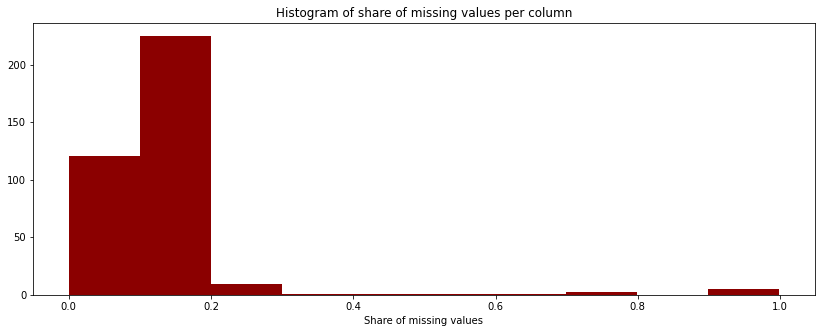

In [19]:
plt.rcParams["figure.figsize"] = (14,5)
plt.hist(azdias_null_share["share"], color = 'darkred')
plt.xlabel('Share of missing values')
plt.title('Histogram of share of missing values per column');

From this figure we can determine that we can eliminate all columns with more than 40% missing values.

In [20]:
drop_columns = list(azdias_null_share[azdias_null_share['share']>0.4]['index'])

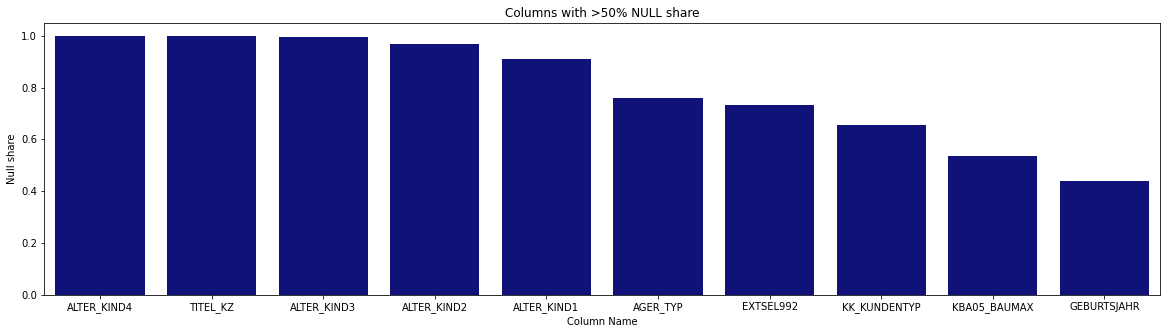

In [21]:
plt.rcParams["figure.figsize"] = (20,5)
sns.barplot(data = azdias_null_share[azdias_null_share['index'].isin(drop_columns)],
x = 'index',
y = 'share',
color = 'darkblue'
)
plt.xlabel('Column Name')
plt.ylabel('Null share')
plt.title('Columns with >50% NULL share');



In the following, we explore eliminating rows with missing values as eliminating incomplete entries can also contribute to improve our fit.

In [22]:
azdias_nrows_count = az_clean.isnull().sum(axis=1)
azdias_nrows_share = pd.DataFrame({'share':azdias_nrows_count/az_clean.shape[1]}).sort_values(by='share',ascending=False)


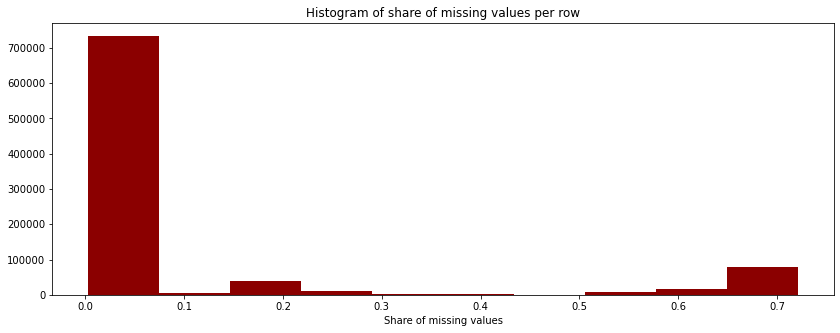

In [23]:
plt.rcParams["figure.figsize"] = (14,5)
plt.hist(azdias_nrows_share["share"], color = 'darkred')
plt.xlabel('Share of missing values')
plt.title('Histogram of share of missing values per row');

From this figure we determine, we can drop all rows with more than half of the columns empty.

In [24]:
drop_rows = azdias_nrows_share[azdias_nrows_share['share']>= 0.5].index
print("Dropping all rows with more than 50% of empty columns will result on a loss of {}% of the rows".
      format(round(len(drop_rows)*100/azdias.shape[0],2)))

Dropping all rows with more than 50% of empty columns will result on a loss of 11.22% of the rows


### Data cleaning <a class="anchor" id="dataclean"></a>

In addition to eliminating empty values, we also address the following:
* Removing redundant columns or with many unique values
* Parsing columns to their correct data format according their content (*e.g.*, dates as dates, numbers as float or int, etc.).

In [25]:
az_clean2 = fn.clean_data(df = az_clean, drop_rows= drop_rows, drop_cols= drop_columns)

In [26]:
# Print new shape and datatypes
print("Old shape: {}".format(azdias.shape))
print("New shape: {} \n".format(az_clean2.shape))
print("Datatypes:")
print(az_clean2.dtypes.value_counts())

Old shape: (891221, 366)
New shape: (791250, 356) 

Datatypes:
float64    265
int64       88
object       3
dtype: int64


In [27]:
cat_columns = az_clean2.select_dtypes(['object']).columns
print(az_clean2[cat_columns].describe())        

       CAMEO_DEU_2015 CAMEO_INTL_2015 D19_LETZTER_KAUF_BRANCHE
count          786772          786772                   613716
unique             44              42                       35
top                6B              51            D19_UNBEKANNT
freq            56410           77329                   189621


In [28]:
for c in cat_columns:
    print('{} has {} unique values with the following content:'.format(c, az_clean2[c].nunique()))
    print(az_clean2[c].unique())

CAMEO_DEU_2015 has 44 unique values with the following content:
['8A' '4C' '2A' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '5C' '8B' '7A' '5D'
 '9E' '9B' '1B' '3D' nan '4E' '4B' '3C' '5A' '7B' '9A' '6D' '6E' '2C' '7C'
 '9C' '7D' '5E' '1D' '8D' '6C' '6A' '5B' '4D' '3A' '2B' '7E' '3B' '6F'
 '5F' '1C']
CAMEO_INTL_2015 has 42 unique values with the following content:
[51.0 24.0 12.0 43.0 54.0 22.0 14.0 13.0 15.0 33.0 41.0 34.0 55.0 25.0 nan
 23.0 31.0 52.0 35.0 45.0 44.0 32.0 '22' '24' '41' '12' '54' '51' '44'
 '35' '23' '25' '14' '34' '52' '55' '31' '32' '15' '13' '43' '33' '45']
D19_LETZTER_KAUF_BRANCHE has 35 unique values with the following content:
[nan 'D19_UNBEKANNT' 'D19_SCHUHE' 'D19_ENERGIE' 'D19_KOSMETIK'
 'D19_VOLLSORTIMENT' 'D19_SONSTIGE' 'D19_BANKEN_GROSS'
 'D19_DROGERIEARTIKEL' 'D19_HANDWERK' 'D19_BUCH_CD' 'D19_VERSICHERUNGEN'
 'D19_VERSAND_REST' 'D19_TELKO_REST' 'D19_BANKEN_DIREKT' 'D19_BANKEN_REST'
 'D19_FREIZEIT' 'D19_LEBENSMITTEL' 'D19_HAUS_DEKO' 'D19_BEKLEIDUNG_REST'
 'D19_SAMME

The following actions need to be made regarding these categorical variables:

* Even though `CAMEO_DEU_2015` has many unique values, the information that it provides is important. As this information is repeated in `CAMEO_INTL_2015` there is no need to keep both columns and `CAMEO_INTL_2015` can be dropped. `D19_LETZTER_KAUF_BRANCHE` has too many unique values and should be dropped. `LNR` is an internal identification number that can also be dropped.

* `CAMEO_DEUG_2015` can be converted to integer.

* `EINGEFUEGT_AM` needs to be cast into date from its current string format. 
* `OST_WEST_KZ` can be coded into "W"=1 AND "E"=0

In [29]:
drop_columns = drop_columns + ['CAMEO_INTL_2015','D19_LETZTER_KAUF_BRANCHE', 'LNR']
drop_columns

['ALTER_KIND4',
 'TITEL_KZ',
 'ALTER_KIND3',
 'ALTER_KIND2',
 'ALTER_KIND1',
 'AGER_TYP',
 'EXTSEL992',
 'KK_KUNDENTYP',
 'KBA05_BAUMAX',
 'GEBURTSJAHR',
 'CAMEO_INTL_2015',
 'D19_LETZTER_KAUF_BRANCHE',
 'LNR']

In [30]:
az_clean2.drop(['CAMEO_INTL_2015','D19_LETZTER_KAUF_BRANCHE', 'LNR'], axis = 1, inplace = True)

In the same way the customers dataset needs to be cleaned. There are, however additional columns which are not found in the German data. 

In [31]:
## The customers data set
diff_cols = list(set(customers.columns) - set(azdias.columns))

In [32]:
customers_nrows_count = customers.isnull().sum(axis=1)
customers_nrows_share = pd.DataFrame({'share':customers_nrows_count/customers.shape[1]}).sort_values(by='share',ascending=False)
customers_drop_rows = customers_nrows_share[customers_nrows_share['share']>= 0.5].index


In [33]:
customers_clean = fn.clean_data(df = customers, drop_rows = customers_drop_rows, drop_cols = drop_columns + diff_cols)

In [34]:
# Print new shape and datatypes
print("Old shape: {}".format(customers.shape))
print("New shape: {} \n".format(customers_clean.shape))
print("Datatypes:")
print(customers_clean.dtypes.value_counts())

Old shape: (191652, 369)
New shape: (140901, 353) 

Datatypes:
float64    260
int64       92
object       1
dtype: int64


### Feature Engineering <a class="anchor" id="featureengineering"></a>

In addition to cleaning the data set, some feature engineering work needs to be done. In this section we address imputing empty values, and transforming/standarizing features depending on the column type.

In [35]:
## Imputing pipe line for binary variables
bin_cols = fn.find_binary_cols(az_clean2)
print("Binary features", bin_cols)

bin_pipe = Pipeline([('bin_impute'
                             , SimpleImputer(missing_values=np.nan
                                             , strategy='most_frequent'
                                            )
                            )])

Binary features ['DSL_FLAG', 'GREEN_AVANTGARDE', 'HH_DELTA_FLAG', 'KBA05_SEG6', 'KONSUMZELLE', 'OST_WEST_KZ', 'SOHO_KZ', 'UNGLEICHENN_FLAG', 'VERS_TYP', 'ANREDE_KZ']


In [36]:
## Imputing and encoding for categorical variables

cat_cols = fn.find_cat_cols(az_clean2)
print("Categorical features", cat_cols)

cat_pipe = Pipeline([
    ('cat_impute', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

Categorical features ['CAMEO_DEU_2015']


In [37]:
## Imputing for remaining numerical variables

num_cols = list(set(az_clean2.columns) - set(bin_cols) - set(cat_cols))
print("Numerical features (first 10 on the list)", num_cols[1:10])

num_pipe = Pipeline([
    ('num_impute', SimpleImputer(missing_values=np.nan, strategy='median')),
    ('num_scale', StandardScaler())
])


Numerical features (first 10 on the list) ['FINANZ_ANLEGER', 'D19_VERSAND_ANZ_12', 'KBA13_HALTER_25', 'D19_VERSAND_ANZ_24', 'PLZ8_ANTG1', 'KBA13_NISSAN', 'KBA13_CCM_2501', 'KBA13_BJ_2008', 'KBA05_SEG5']


In [38]:
### Combining transformers

column_transformer = ColumnTransformer(
    transformers = [
        ('bin', bin_pipe, bin_cols),
        ('cat', cat_pipe, cat_cols),
        ('num', num_pipe, num_cols)
    ]
)
az_clean2[cat_cols] = az_clean2[cat_cols].astype('str')
az_trans = column_transformer.fit_transform(az_clean2)

In [39]:
## Transform az_trans to a data frame (recover column names from transformator)

onehot_names = list(column_transformer.transformers_[1][1].named_steps['onehot'].get_feature_names(cat_cols))
col_names = bin_cols + onehot_names + num_cols
az_df = pd.DataFrame(az_trans, columns = [col_names])

In [40]:
## Check data types in transformed data set
az_df.dtypes.value_counts()

float64    397
dtype: int64

In [ ]:
## Pickle transformed dataset 

# pickle.dump(az_df, open('az_df.pckl','wb'))

## Part 1: Customer Segmentation Report <a class="anchor" id="customersegm"></a>

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

### Principal Component Analysis <a class="anchor" id="pca"></a>

In [ ]:
# az_df = pickle.load(open('data/az_df.pckl','rb'))

In [41]:
az_df.shape[1]

397

The transformed German dataset has 397 different features even after the data cleaning process. In order to reduce the number of features an approach such as Principal Component Analysis can be applied.

In [42]:
## Fit the PCA model

az_pca = PCA().fit(az_df)

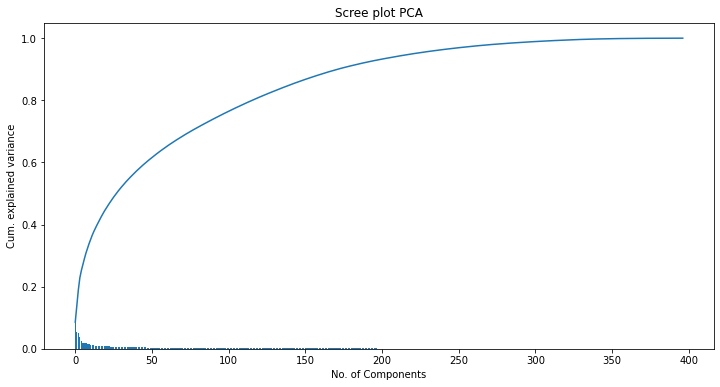

In [43]:
fn.scree_plot(az_pca)

From this plot we observe that around 200 components explain more than 90% of the variance, which means we can reduce our dataset to almost half of the features without loosing much predictive power.

In [44]:
pca_red = PCA(n_components=200).fit(az_df)
az_red = pd.DataFrame(pca_red.transform(az_df))

### K-Means <a class="anchor" id="kmeans"></a>

We know we can reduce the features in the data for clustering, however, as we make use of a K-Means algorithm for clustering, we still need to determine the no. of clusters required. This can be done, *e.g.* by using the elbow method.

In [45]:
## Loop over a range of possible cluster values

sum_squared_d = []

for i in np.arange(2,41):
    k = KMeans(n_clusters = i, init = "k-means++")
    k.fit(az_red.sample(10000))
    sum_squared_d.append(k.inertia_)

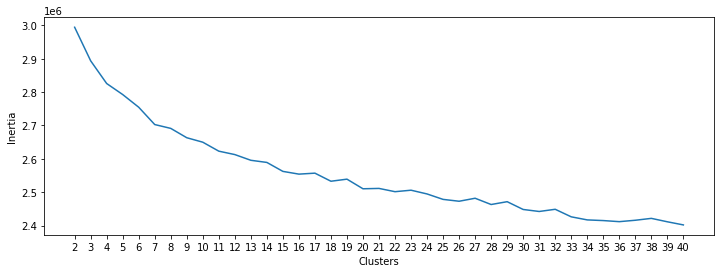

In [46]:
## Plot sum_squares vs. no. of clusters

plt.figure(figsize = (12,4))
plt.plot(np.arange(2,41), sum_squared_d, '-')
plt.xticks(np.arange(2,41))
plt.xlabel("Clusters")
plt.ylabel("Inertia");

Although not entirely clear from the plot, we observe that the inertia reduces drastically in the range of 2 to 7 clusters. This constitutes the first elbow from the curve and, which means no further (impactful) gains can be achieved by increasing the number of clusters to more than 7. 

### Cluster analysis <a class="anchor" id="clusteranalysis"></a>

Once we obtained to which level we can reduce the features of the dataset (*i.e.*, PCA) and the optimal number of clusters to fit (*i.e.*, elbow method for K-Means) then we can proceed to cluster the data to proceed with our analysis. Briefly explained, the approach we use is to fit the reduced German population into K-Means and use the same model to predict the clustering of the customers dataset. Once obtained, the clusters per sample can be compared to determine which group of customers are over- or underrepresented with respect to the general German population.

In [47]:
## Setup pipeline to reduce and cluster data

n_components = 200
n_clusters = 7

cluster_pipe = Pipeline([
    ('transform', column_transformer)
    ,('reduction', PCA(n_components= n_components))
    ,('clustering', KMeans(n_clusters = n_clusters, init = 'k-means++'))
])
cluster_pipe.fit(az_clean2)

Pipeline(steps=[('transform',
                 ColumnTransformer(transformers=[('bin',
                                                  Pipeline(steps=[('bin_impute',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['DSL_FLAG',
                                                   'GREEN_AVANTGARDE',
                                                   'HH_DELTA_FLAG',
                                                   'KBA05_SEG6', 'KONSUMZELLE',
                                                   'OST_WEST_KZ', 'SOHO_KZ',
                                                   'UNGLEICHENN_FLAG',
                                                   'VERS_TYP', 'ANREDE_KZ']),
                                                 ('cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleIm

In [49]:
## Create clustered dataframes

az_clust = pd.DataFrame(cluster_pipe.predict(az_clean2), columns = ["Cluster"])
customers_clust = pd.DataFrame(cluster_pipe.predict(customers_clean), columns = ["Cluster"])


In [50]:
## Join clustered datasets into one dataframe

clusters = pd.DataFrame({'Germany':az_clust.value_counts().sort_index()
              , 'Customers':customers_clust.value_counts().sort_index()}).reset_index()
clusters['Cluster'] += 1
clusters['Germany_share'] = clusters['Germany']/clusters['Germany'].sum()
clusters['Customers_share'] = clusters['Customers']/clusters['Customers'].sum()
clusters['Delta'] = clusters['Customers_share'] - clusters['Germany_share']


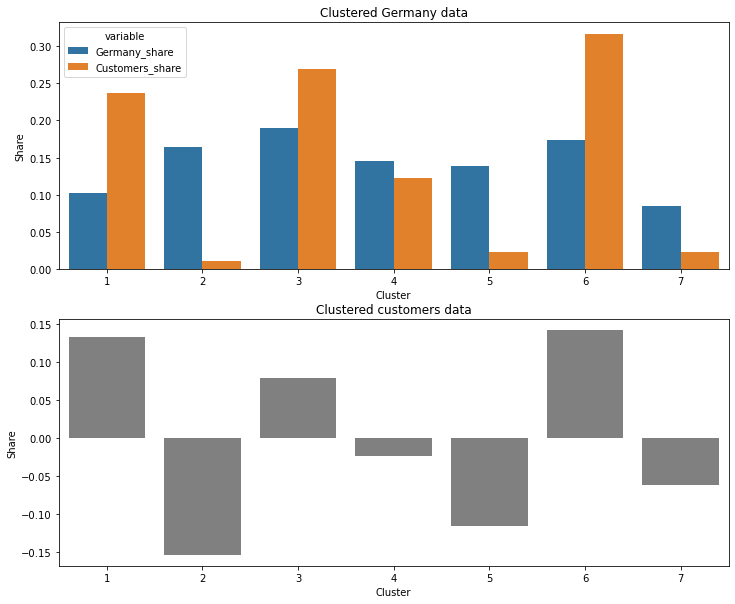

In [51]:
# # Plot clusters 

plt.rcParams["figure.figsize"] = (12,10)

plt.subplot(2,1,1)

sns.barplot(data = clusters.drop(['Germany', 'Customers', 'Delta'], axis = 1).melt(id_vars = ['Cluster']),
x = 'Cluster',
y = 'value',
hue = 'variable'
)
plt.xlabel('Cluster')
plt.ylabel('Share')
plt.title('Clustered Germany data');

plt.subplot(2,1,2)

sns.barplot(data = clusters,
x = 'Cluster',
y = 'Delta',
color = 'grey'#'darkred'
)
plt.xlabel('Cluster')
plt.ylabel('Share')
plt.title('Clustered customers data');

From these graphs we make the following observations:
* The German data is somewhat balanced across clusters with the exception of clusters 3 and 5. The Customers data, in contrast, is highly concentraded in few clusters (1 to 4).
* Precisely clusters 2, 3, 4 are the most overrepresented clusters in comparison to the German data, as seen by the positive difference in shares. Clusters 5, 6, and 7, on the other hand, are underepresented with respect to the German data, as the difference in shares is negative.
* Focus clusters can be selected by choosing the clusters with a share difference of more than 10% with respect to the general population.

The recommendation to the marketing campaing, thus, is to focus on the customers in clusters 3 and 4 as they stand out from the general population whereas clusters 6 and 7 are quite underepresented and should not be part of the focus group.

In [52]:
## Extract the values of cluster centers for all clusters
cluster_centers = fn.get_cluster_centers(cluster_pipe, num_cols,col_names)

In [53]:
## Separate focus vs non focus clusters selected based on our analysis
focus_clusters = cluster_centers.iloc[[2,3, 5, 6]].T
focus_clusters.columns += 1
focus_clusters_red = focus_clusters[focus_clusters.std(axis = 1)>1.5].sort_index()
focus_clusters_red
# nfocus_cluster = cluster_centers.iloc[[8,11,17]].T

,3,4,6,7
ALTER_HH,15.662857,7.247941,9.044046,9.973776
ANZ_HAUSHALTE_AKTIV,2.820323,14.795101,2.103233,12.688667
ANZ_STATISTISCHE_HAUSHALTE,2.586958,13.726634,2.142859,11.882809
CAMEO_DEUG_2015,4.166483,7.201517,4.013277,7.220345
D19_GESAMT_ANZ_24,3.833647,0.414451,0.744026,0.927662
D19_GESAMT_DATUM,2.703904,8.501336,7.575541,7.523141
D19_GESAMT_ONLINE_DATUM,3.483728,9.098536,8.504370,8.138450
D19_GESAMT_ONLINE_QUOTE_12,7.812242,0.752214,1.356070,1.943288
D19_KONSUMTYP,2.491496,6.381606,5.996348,5.867031
D19_KONSUMTYP_MAX,2.144309,7.129255,5.843759,6.184279


Based on the previous table, we can infer the following traits for customers in both focus and non-focust customer segments:

*Focus Clusters*
* Mid to High-income
* Mainly couples
* Older than non-focus demographic
* Living in single home, duplex or small apartment buildings
* More consumption-oriented

*Non-focus Clusters*
* Low-income
* Mainly singles
* Younger than focus demographic
* Living in big apartment buildings with many household
* Less consumption oriented

## Part 2: Supervised Learning Model <a class="anchor" id="supervisedlearningmodel"></a>

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [54]:
# mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')
mailout_train = pd.read_csv('data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

/Users/Emilio/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [55]:
## Clean the data
mailout_train_clean = pd.concat(\
                               [fn.clean_data(mailout_train.drop(['RESPONSE'], axis = 1), drop_cols = drop_columns),\
                               mailout_train['RESPONSE']],\
                               axis = 1)

In [56]:
# Print new shape and datatypes
print("Old shape: {}".format(mailout_train.shape))
print("New shape: {} \n".format(mailout_train_clean.shape))
print("Datatypes:")
print(mailout_train_clean.dtypes.value_counts())

Old shape: (42962, 367)
New shape: (42962, 354) 

Datatypes:
float64    262
int64       91
object       1
dtype: int64


In [57]:
## Transform data, impute missing values and separate features from response variables

X = mailout_train_clean.drop(['RESPONSE'], axis = 1)
X = column_transformer.fit_transform(X)
X = pd.DataFrame(X, columns = [col_names])
y = mailout_train_clean['RESPONSE']

### Class imbalance <a class="anchor" id="classimb"></a>

The response variable of this dataset is highly imbalanced, as it can be observed in the following plot:

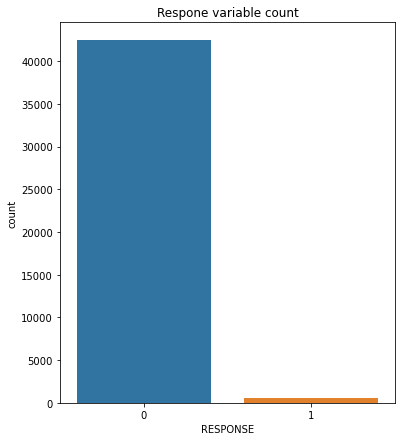

In [58]:
### class imbalance plot
plt.figure(figsize = (6 , 7))
sns.countplot(data = mailout_train_clean, x = 'RESPONSE')
plt.title('Respone variable count');



This fact cant greatly impact the quality of the prediction model as the prediction accuracy cannot be properly meassured. In order to overcome this, there is the possibility of over- or undersampling the current dataset to improve the response balance. Furthermore, the [SMOTE](https://www.analyticsvidhya.com/blog/2020/10/overcoming-class-imbalance-using-smote-techniques) approach further enhances under- and oversampling by incorporating generated synthetic samples. 

In [59]:
## Apply SMOTE

oversample = SMOTE(random_state= 42)
X_bal, y_bal = oversample.fit_resample(X,y) 

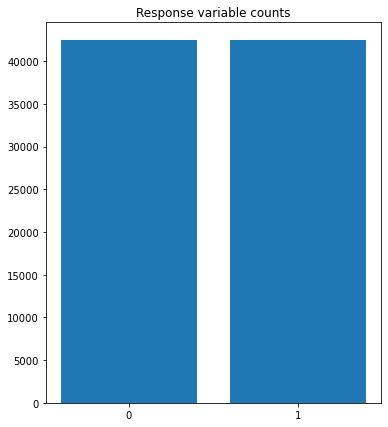

In [61]:
plt.figure(figsize = (6 , 7))
plt.bar(x= [0,1], height = y_bal.value_counts())
plt.xticks([0,1])
plt.title('Response variable counts');

### Model selection <a class="anchor" id="modelselection"></a>

In this section we train different classification models to determine which approach is more suitable for our present task. Once selected, the best model can be further optimized by hyperparameter tuning.

In [62]:
## Define candidate models
models = {'RandomForestClassifier': RandomForestClassifier(), 
          'AdaBoostClassifier': AdaBoostClassifier(), 
          'GradientBoostingClassifier': GradientBoostingClassifier(),
          'BaggingClassifier': BaggingClassifier()
         }



In [ ]:
## Run crossvalidation to plot learning curves and determine best model
    
cv = ShuffleSplit(n_splits=2, test_size=0.2, random_state=0)

for model_key in models.keys():
    print(model_key)
    ml_pipeline = Pipeline([
        ('model', models[model_key])
    ])
    
    fn.plot_learning_curve(ml_pipeline, title = "test",
                          X = X_bal, y = y_bal, cv = cv,
                          verbose = 0, n_jobs = -1)
    plt.show()


RandomForestClassifier


From these experiments we can observe the following:
* The `RandomForestClassifier` presented simultaneously the best traning score and the worst validation score. This indicates that this model is overfitting (*i.e.* shows high model bias) and therefore will not be chosen
* The `AdaBoostClassifier` and the `GradientBoostingClassifier` both show less model bias as the training and validation score converge (this occurs already after 40-50-% of the data is presented to the algorithm). Nevertheless for our classification problem we choose `GradientBoostingClassifier` as it showed the highest mean cv score. 


### Hyperparameter Tuning <a class="anchor" id="tuning"></a>

Now that we selected `GradientBoostingClassifier` as our classification algorithm the next step is to tune is parameters. This can be achieved through a grid-search on which a combination of series of parameters can be tested to select the best configuration.

In [ ]:
### Define search grid
grid_pipe = Pipeline([
    ('gbc', GradientBoostingClassifier(random_state = 42))
])

parameters = {'gbc__learning_rate': [0.1, 0.2]
              , 'gbc__n_estimators': [100]
              , 'gbc__max_depth': [3, 5]
              , 'gbc__min_samples_split': [2,4]}        
        
grid_opt = GridSearchCV(grid_pipe
                        , parameters
                        , scoring = 'roc_auc'
                        , verbose=2)

## Fit model with grid parameters
grid_opt.fit(X, y)


## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter.

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [ ]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')